Imports section. You basically neet to install the JupyterLab, MatPlotLib and Pandas libraries. To use some interactions in the notebook we are using ipywidgets as well.  
These are the pip commands to install the packes:  
**pip install jupyterlab  
pip install pandas  
pip install matplolib  
pip install ipywidgets**  
  
In order to get ipywidgets working with jupyter notebook please run the following command:  
**jupyter nbextension enable --py --sys-prefix widgetsnbextension**  
    
If you're using jupyter lab you also have to register the extension:  
**jupyter labextension install @jupyter-widgets/jupyterlab-manager**  
  
Please refer to: [https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md)  
  
When exectuing the second command you may wonder that the terminal is somehow standing still. Don't worry, start the jupyter notebook in a second terminal using:  
**jupyter lab**  
  
For your convenience we added all of these indivdual installtion to one requirements text file that you can execute using the one and only following command (you will find requirements.txt in the root folder of this project):  
**pip install -r requirements.txt**  
  

In [20]:
import pandas as pd
import numpy as np
import math
import re
import time
import datetime
import os
import requests
import re
from datetime import date
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates



And now the class. The constructor takes a string containing the full filenname of a CSV database you can down load from the WHO website:<br>
  
[European Center of Disease Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide) 
  
For your convenience the class provides a static method to download the file. The database will be loaded and kept as a private member. To retrieve the data for an indvidual country or a list of countries you can use the public methods **GetCountryDataByGeoID** or **GetCountryDataByCountryName**. Refer to the CSV file for a list of available GeoIDs and CountryNames. Both methods will return a list of the following attributes as a Pandas data frame:  
  
**Date** The date of the data  
**Country** The name of the country  
**GeoID** The GeoID of the country such as FR for France or DE for Germany  
  
**Cases** The number of cases on that day  
**CumulativeCases** The accumulated number of cases since the 31.12.2019  
**DoublingTime** The number of days in which the number of cases will be doubled  
  
**Deaths** The number of deaths on the date  
**CumulativeDeaths** The accumulated number of deaths since the 31.12.2019   
**PercentDeaths** The number of deaths in % of the cases  
  
**CasesPerMillionPopulation** The number of cumulative cases devide by the popolation of the countryy in million      
**DeathsPerMillionPopulation** The number of cumulative deaths devide by the popolation of the countr in million  
  
There is a function that will lowpass any of the above attributes called **add_lowpass_filter_for_attribute**. The width of the lowpass is given by the number **n**. The name of the newly created attribute is the given name with a tailing number **n**. E.g. if you filter the attribute **Cases** with n = 7 then the function will add to a newly created attribute named **Cases7**.
There is also a function to calculate an estimation for the reproduction number R0 called **add_r0**. If you call that function it will add a newly created attribute named **R**. This attribute should be filtered by a lowpass of width n = 7 as shown in this example. If required you may want to save the results to a CSV file. To do so you can use the function **save_df_to_csv**.


In [21]:

class CovidCases:
    """
    The constructor takes a string containing the full filenname of a CSV
    database you can down load from the WHO website:
    https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
    The database will be loaded and kept as a private member. To retrieve the
    data for an indvidual country you can use the public methods
    GetCountryDataByGeoID or GetCountryDataByCountryName. Refer to the CSV
    file for a list of available GeoIDs and CountryNames. Both methods will
    return a list of the following fields as a JSON:

    Date
    The date of the data Country The name of the country

    GeoID
    The GeoID of the country such as FR for France or DE for Germany

    Continent
    the continet of the country

    Cases
    The number of cases on that day

    CumulativeCases
    The accumulated number of cases since the 31.12.2019

    DoublingTime
    The number of days in which the number of cases will be doubled
    
    Deaths
    The number of deaths on the date

    CumulativeDeaths
    The accumulated number of deaths since the 31.12.2019

    PercentDeaths
    The number of deaths in % of the cases
    
    CasesPerMillionPopulation
    The number of cumulative cases devide by the popolation of the countryy in million

    DeathsPerMillionPopulation
    The number of cumulative deaths devide by the popolation of the countr in million
    """

    def __init__(self, filename):
        """
        constructor
        """
        # some benchmarking
        start = time.time()
        # open the file
        self.__df = pd.read_csv(filename)
        # remove columns that we don't need
        self.__df = self.__df.drop(columns=['day', 
                                            'month', 
                                            'year', 
                                            'countryterritoryCode', 
                                            'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
        # rename the columns to be more readable
        self.__df.columns = ['Date',
                             'Cases',
                             'Deaths',
                             'Country',
                             'GeoID',
                             'Population',
                             'Continent']
        # change the type of the 'date' field to a pandas date
        self.__df['Date'] = pd.to_datetime(self.__df['Date'],
                                           format='%d/%m/%Y')
        # some benchmarking
        end = time.time()
        print('Panda loading the CSV: ' + str(end - start) + 's')
        
    @staticmethod
    def download_CSV_file():
        """
        automatically downloads the database file if it doesn't exists. need
        to be called in a try-catch block as it may throw FileNotFoundError or
        IOError errors
        """
        # todays date
        today = date.today()
        # the prefix of the CSV file is Y-m-d
        preFix = today.strftime('%Y-%m-%d')
        try:
            get_ipython
            # the absolut directory of this python file
            absDirectory = os.path.dirname(os.path.abspath(os.path.abspath('')))
            # the target filename
            targetFilename = os.path.join(absDirectory, './data/' + preFix + '-db.csv')
        except:
            # the absolut directory of this python file
            absDirectory = os.path.dirname(os.path.abspath(__file__))
            # the target filename
            targetFilename = os.path.join(absDirectory, '../data/' + preFix + '-db.csv')
        # check if it exist already
        if os.path.exists(targetFilename):
            print('using existing file: ' + targetFilename)
        else:
            # doownload the file from the ecdc server
            url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/'
            r = requests.get(url, timeout=1.0)
            if r.status_code == requests.codes.ok:
                with open(targetFilename, 'wb') as f:
                    f.write(r.content)
            else:
                raise FileNotFoundError('Error getting CSV file. Error code: ' + str(r.status_code))
        return targetFilename

    @staticmethod
    def __compute_doubling_time(dfSingleCountry):
        """
        Computes the doubling time for everyday day with the formular:
                ln(2) / ln(Conf[n] / Conf[n - 1])
        returns it as a dataframe
        """
        result = []
        quotient = []
        for index, value in dfSingleCountry['CumulativeCases'].iteritems():
            #  calculating the quotient conf[n] / conf[n-1]
            if index > 0 and index - 1 != 0:
                quotient.append(value / dfSingleCountry['CumulativeCases'][index - 1])
            else:
                quotient.append(math.nan)
            # calculates the doubling time (can't be calculated when there's 
            # no change from one day to the other)
            if quotient[index] != 1 and quotient[index] != math.nan:
                result.append(math.log(2) / math.log(quotient[index]))
            else:
                result.append(math.nan)
        # return the dataframe
        return pd.DataFrame(np.asarray(result))

    def __add_additional_attributes(self, dfSingleCountry):
        """
        Adds additional attributes to a dataframe of a single country.   
        """
        # reset the index on the dataframe (if the argument is just a slice)
        dfSingleCountry.reset_index(inplace=True, drop=True)
        
        # the cumlative cases
        dfSingleCountry['CumulativeCases'] = dfSingleCountry['Cases'].cumsum()
        # the cumlative cases
        dfSingleCountry['CumulativeDeaths'] = dfSingleCountry['Deaths'].cumsum()
        # the percentage of deaths of the cumulative cases
        dfSingleCountry['PercentDeaths'] = pd.DataFrame({'PercentDeaths': 
                                                         dfSingleCountry['CumulativeDeaths'] * 100 / 
                                                         dfSingleCountry['CumulativeCases']})
        # the percentage of cumulative cases of the 1 million population
        dfSingleCountry['CasesPerMillionPopulation'] = pd.DataFrame({'CasesPerMillionPopulation': 
                                                                     dfSingleCountry['CumulativeCases'].div(dfSingleCountry['Population'].iloc[0] / 1000000)})
        # the percantage of cumulative deaths of 1 million population
        dfSingleCountry['DeathsPerMillionPopulation'] = pd.DataFrame({'DeathsPerMillionPopulation': 
                                                                      dfSingleCountry['CumulativeDeaths'].div(dfSingleCountry['Population'].iloc[0] / 1000000)})
        # adds the extra attributes
        dfSingleCountry['DoublingTime'] = self.__compute_doubling_time(dfSingleCountry)
        # return the manipulated dataframe
        return dfSingleCountry

    def __apply_lowpass_filter(self, dfAttribute, n):
        """
        Returns a dataframe containing the lowpass filtered (with depth n) 
        data of the given dataframe.
        """
        result = []
        # iterate the attribute
        for index, value in dfAttribute.iteritems():
            # if the dataframe contains NaN, leave it untouched
            if math.isnan(value):
                result.append(math.nan)
                continue
            if index == 0:
                result.append(value)
            # for all rows below the nth row, calculate the lowpass filter up to this point
            elif index < n:
                result.append(sum(dfAttribute[0:index + 1]) / (index + 1))
            else:
                start = index - n + 1
                result.append(sum(dfAttribute[start:start + n]) / n)
        # return the calculated data as an array
        return pd.DataFrame(np.asarray(result))

    def add_lowpass_filter_for_attribute(self, df, attribute, n):
        """
        Adds a atribute to the df of each country that is the lowpass filtered
        data of the given attribute. The width of the lowpass is given by then
        number n. The name of the newly created attribute is the given name
        with a tailing number n. E.g. 'Cases' with n = 7 will add to a newly
        added attribute named 'Cases7'.
        If the attribute already exists the function will return the given df.
        """
        # check if the attribute already exists
        requestedAttribute = attribute + str(n)
        for col in df.columns:
            if col == requestedAttribute:
                return df
        # get all GeoIDs in the df
        geoIDs = df['GeoID'].unique()
        # our result data frame
        dfs = []
        for geoID in geoIDs:
            # get the country dataframe
            dfSingleCountry = df.loc[df['GeoID'] == geoID].copy()
            # reset the index to start from index = 0
            dfSingleCountry.reset_index(inplace=True, drop=True)
            # add the lowpass filtered attribute
            dfSingleCountry[requestedAttribute] = self.__apply_lowpass_filter(dfSingleCountry[attribute], 7)
            # add the coiuntry to the result
            dfs.append(dfSingleCountry)
        return pd.concat(dfs)

    def __apply_r0(self, dfCases):
        """
        Returns a dataframe containing an estimation for the reproduction
        number R0 of the dataframe given. The given dataframe has to contain
        'Cases'.
        """
        # add the r0 attribute
        result = []
        # we will create 2 blocks and sum the data of each block
        blockSize = 4
        # iterate the cases
        for index, value in dfCases.iteritems():
            if index < 2 * blockSize - 1:
                result.append(math.nan)
            else:
                # the sum of block 0
                start = index - (2 * blockSize - 1)
                sum0 = sum(dfCases[start: start + blockSize])
                # the sum of block 1
                start = index - (blockSize - 1)
                sum1 = sum(dfCases[start: start + blockSize])
                # and R
                if sum0 == 0:
                    R = math.nan
                else:
                    R = sum1 / sum0
                result.append(R)
        # return the calculated data as an array
        return pd.DataFrame(np.asarray(result))

    def add_r0(self, df):
        """
        Adds a atribute to the df of each country that is an estimation of the
        reproduction number R0. Here the number is called 'R'. The returned
        dataframe should finally lowpassed filtered with a kernel size of 1x7.
        If the attribute already exists the function will return the given df.
        """
        # check if the attribute already exists
        requestedAttribute = 'R'
        for col in df.columns:
            if col == requestedAttribute:
                return df
        # get all GeoIDs in the df
        geoIDs = df['GeoID'].unique()
        # our result data frame
        dfs = []
        for geoID in geoIDs:
            # get the country dataframe
            dfSingleCountry = df.loc[df['GeoID'] == geoID].copy()
            # reset the index to start from index = 0
            dfSingleCountry.reset_index(inplace=True, drop=True)
            # add the lowpass filtered attribute
            dfSingleCountry[requestedAttribute] = self.__apply_r0(dfSingleCountry['Cases'])
            # add the coiuntry to the result
            dfs.append(dfSingleCountry)
        return pd.concat(dfs)

    def save_df_to_csv(self, df, filename):
        """
        Saves a df to a CSV file
        """
        df.to_csv(filename)

    def get_country_data_by_geoid_list(self, geoIDs, lastNdays=0, sinceNcases=0):
        """
        Return the dataframe by a list of geoIDs. Optional attributes are:
        lastNdays: returns just the data of the last n days.
        sinceNcases: returns just the data since the nth case.
        """
        # check if only one optional parameter is used
        if lastNdays > 0 and sinceNcases > 0:
            raise ValueError("Only one optional parameter allowed!")
        # our result data frame
        dfs = []
        # get data for each country
        for geoID in geoIDs:
            # get the data for a country and add the additional rows
            df = self.__df.loc[self.__df['GeoID'] == geoID].copy()
            # reverse the data frame to the newest date in the bottom
            df = df.reindex(index=df.index[::-1])
            df.head()
            df = self.__add_additional_attributes(df)
            # if lastNdays is specified just return these last n days
            if lastNdays > 0:
                df = df.tail(lastNdays)
            # if sinceNcases is specified calculate the start index
            if sinceNcases > 0:
                start = -1
                for index, val in df['CumulativeCases'].iteritems():
                    if val >= sinceNcases:
                        start = index
                        break
                # an illegal input will cause an exception
                if start == -1:
                    raise ValueError("Number of cases wasn't that high!")
                # copy the data
                df = df.iloc[start:].copy()
                # reset the index on the remaining data points so that they
                # start at zero
                df.reset_index(inplace=True, drop=True)
            # append this dataframe to our result
            dfs.append(df)
        # return the concatenated dataframe
        return pd.concat(dfs)

    def get_country_data_by_geoid_string_list(self, geoIDstringList, lastNdays=0, sinceNcases=0):
        """
        Return the dataframe by a comma separated list of geoIDs. Optional
        attributes are:
        lastNdays: returns just the data of the last n days.
        sinceNcases: returns just the data since the nth case.
        """
        # split the string
        geoIDs = re.split(r',\s*', geoIDstringList.upper())
        # return the concatenated dataframe
        return self.get_country_data_by_geoid_list(geoIDs, lastNdays, sinceNcases)

    def get_all_country_data(self, lastNdays=0, sinceNcases=0):
        """
        Return the dataframe of all countries. Optional attributes are:
        lastNdays: returns just the data of the last n days.
        sinceNcases: returns just the data since the nth case.
        """
        # return all countries, but first add the extra columns
        return self.get_country_data_by_geoid_list(self.__df['Country'].unique(), lastNdays=lastNdays, sinceNcases=sinceNcases)



We also use a Builder class in this project to plot the data. It's very much configured for our needs of plotting a Pandas DataFrame. When using it you have to pass the name of the DataFrame column you want to plot as a constructor argument. Afterwards you're able to configure multiple plotting configurations like **name**, **figure size**, **y-axis scale** and so on. In the end you pass the DataFrame that should be plotted to the function plot_dataFrame and it outputs a beautiful matplotlib plot.


In [22]:

class PlotterBuilder:
    """
    A class that let's you easily build the wanted plotting configuration. If not further specified you get some
    default values like:
        - A figsize of 12, 8
        - No name
        - No grid
        - A linear y-axis-scale
        - A xaxis DateFormatter with format Y-m-d
    When plotting a DataFrame this class is always grouping by columns.
    """

    def __init__(self, yfield):
        """
        Creates an instance with mentioned default values.
        Parameter:
            yfield: The field of the DataFrame you want to plot.
        """
        self.__figsize = (12, 8)
        self.__title = ""
        self.__grid = False
        self.__yscale = 'linear'
        self.__xaxis_formatter = mdates.DateFormatter('%d/%m/%Y')
        self.__yfield = yfield
        self.__xlabel = ""
        self.__ylabel = ""

    def set_figsize(self, sizes):
        """
        Setter for the figure size.
        """
        self.__figsize = sizes
        return self

    def set_title(self, title):
        """
        Setter for the title.
        """
        self.__title = title
        return self

    def set_grid(self):
        """
        Sets the grid value to True.
        """
        self.__grid = True
        return self

    def set_log(self):
        """
        Formats the yscale to logarithmic.
        """
        self.__yscale = 'log'
        return self

    def set_xaxis_index(self):
        """
        Tells the x-axis that you don't want to plot a date.
        """
        self.__xaxis_formatter = None
        return self

    def set_axis_labels(self, xlabel="", ylabel=""):
        """
        Sets the axis labels.
        """
        self.__xlabel = xlabel
        self.__ylabel = ylabel
        return self

    def build(self):
        """
        Builds the configured plotting object.
        Returns:
             fig: figure object
             ax: axis object with the wanted configurations.
        """
        fig, ax = plt.subplots(1, 1, figsize=self.__figsize)
        ax.set_title(self.__title)
        ax.set_yscale(self.__yscale)
        if self.__xaxis_formatter:
            ax.xaxis.set_major_formatter(self.__xaxis_formatter)
        ax.set(xlabel=self.__xlabel)
        ax.set(ylabel=self.__ylabel)
        return [fig, ax]

    def plot_dataFrame(self, df, ylim_min=None, ylim_max=None, **options):
        """
        Plots the DataFrame. If you want to plot an index on the x-axis you have to set it within the DataFrame object.
        If not the column date is used.
        """
        if self.__xaxis_formatter is None:
            # plot an index, not a date
            pldf = df.pivot_table(values=self.__yfield, index=df.index, columns='Country')
        else:
            # plot it with a date formatted x axis
            pldf = df.pivot_table(values=self.__yfield, index='Date', columns='Country')
        fig, ax = self.build()
        pldf.plot(ax=ax, **options)
        ax.set_ylim(ymin=ylim_min, ymax=ylim_max)
        ax.grid(self.__grid)



We need to download the database from a file provided by the ECDC. As the repository uses Github actions we need to somehow inject special data into the notebook, this is done via this lines of code:


In [23]:

pathToCsv = 'data/db.csv'
githubAction = False



Using the class is pretty simple. Create an instance of the class using the full path to the filename of rhe downloaded dataset and get the data for a specific list of countries by calling<br> <i>df = covidCases.get_country_data_by_geoid_string_list('DE, IT, ES')</i>. The list is a comma separated sting of GeoIDs. The geoID is equal to the country code of a toplevel domain. E.g. <i>DE</i> for Germany, <i>FR</i> for France, <i>JP</i> for Japan or <i>KR</i> for Korea. There is also a function in which you can pass a list of strings having the GeoIDs of the requested contries indicually. This function is called **get_country_data_by_geoid_list**. You can also get a data frame containg all countries by calling **get_all_country_data**. 


In [24]:

if not githubAction:
    pathToCSV = CovidCases.download_CSV_file()
# create an instance
covidCases = CovidCases(pathToCSV)
# a list of countries of whom we want to get the data as a comma separated list
countryList = 'DE, UK, FR, ES, IT'


using existing file: /Users/martinkersting/Documents/GitHub/Covid-19-analysis/./data/2020-08-07-db.csv
Panda loading the CSV: 0.068328857421875s



Next we want to visualise the data in several diagrams. In a first step we need to get the data fields of the different countries that we want to visualise. Next is to select the field that we want to display, indexed by the date having the countriy name as a column.


/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in long_scalars
/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in long_scalars


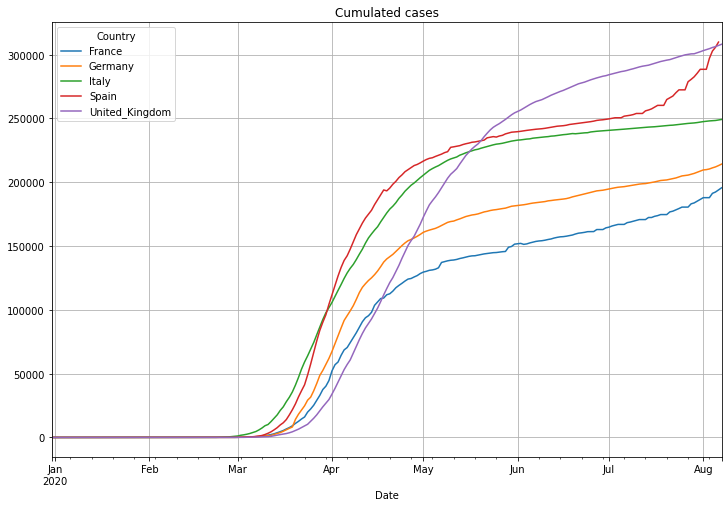

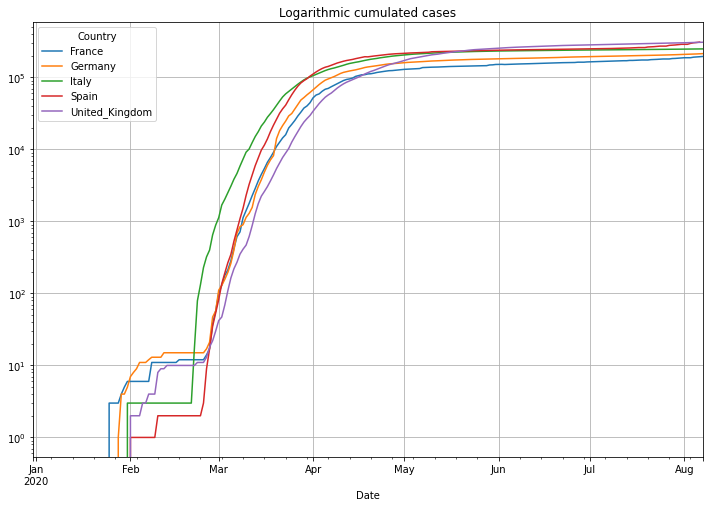

In [25]:

# differntiate between a normal run and a github actions injected run path
if githubAction:
    # get simulated data
    dfdata = [pd.DataFrame(country_data) for country_data in dataAction]
    # get the data
    df = pd.concat(dfdata)
else:
    # get the data
    df = covidCases.get_country_data_by_geoid_string_list(countryList)
    
# plot with various axes scales, first with linear axis scale:
(PlotterBuilder('CumulativeCases') 
    .set_title('Cumulated cases') 
    .set_grid() 
    .plot_dataFrame(df))

# then logarithmic cumulated cases
(PlotterBuilder('CumulativeCases')
    .set_title('Logarithmic cumulated cases')
    .set_grid()
    .set_log()
    .plot_dataFrame(df))



The following shows a graph of cases per day (Notice: UK did something very strange: early July they reported -30000 new cases. The fact that a country corrects previous numbers is somehow normal. But correcting 30000 cases at one day makes it very difficult to analyse the data. To avoid the graph from beeing 'unreadable' we introduced the limit of the y-axis):
    

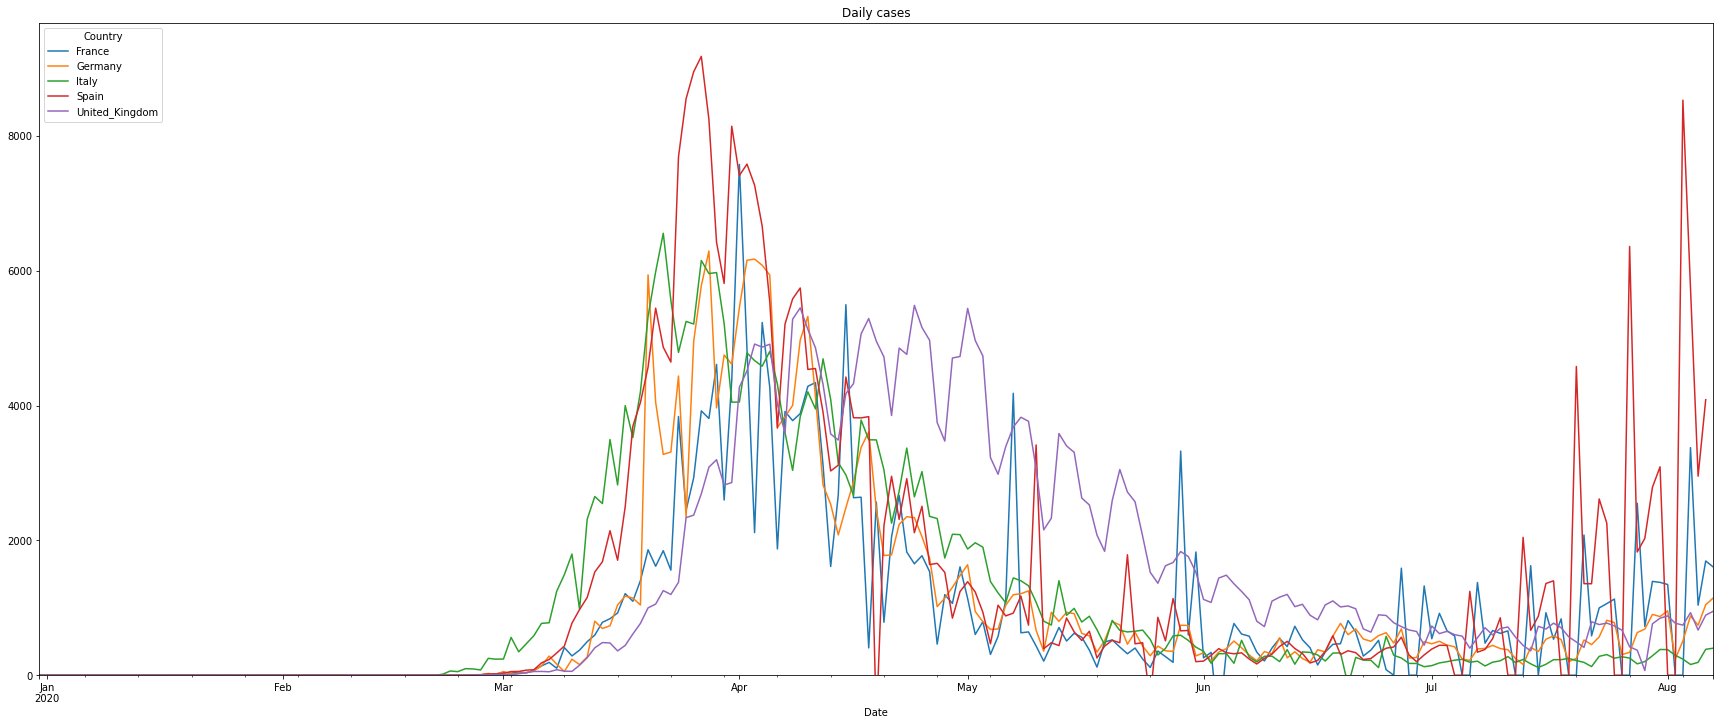

In [26]:

# plot the daily cases, a bar chart doesn't make sense for a longer time
(PlotterBuilder('Cases')
     .set_figsize((30, 12))
     .set_title('Daily cases')
     .plot_dataFrame(df, ylim_min=0))



It's difficult to read the graph as we can see the typical *weekend* behaviour when the data of the cases are not updated. To get rid of this we will visualize the rolling 7-day average number of cases:


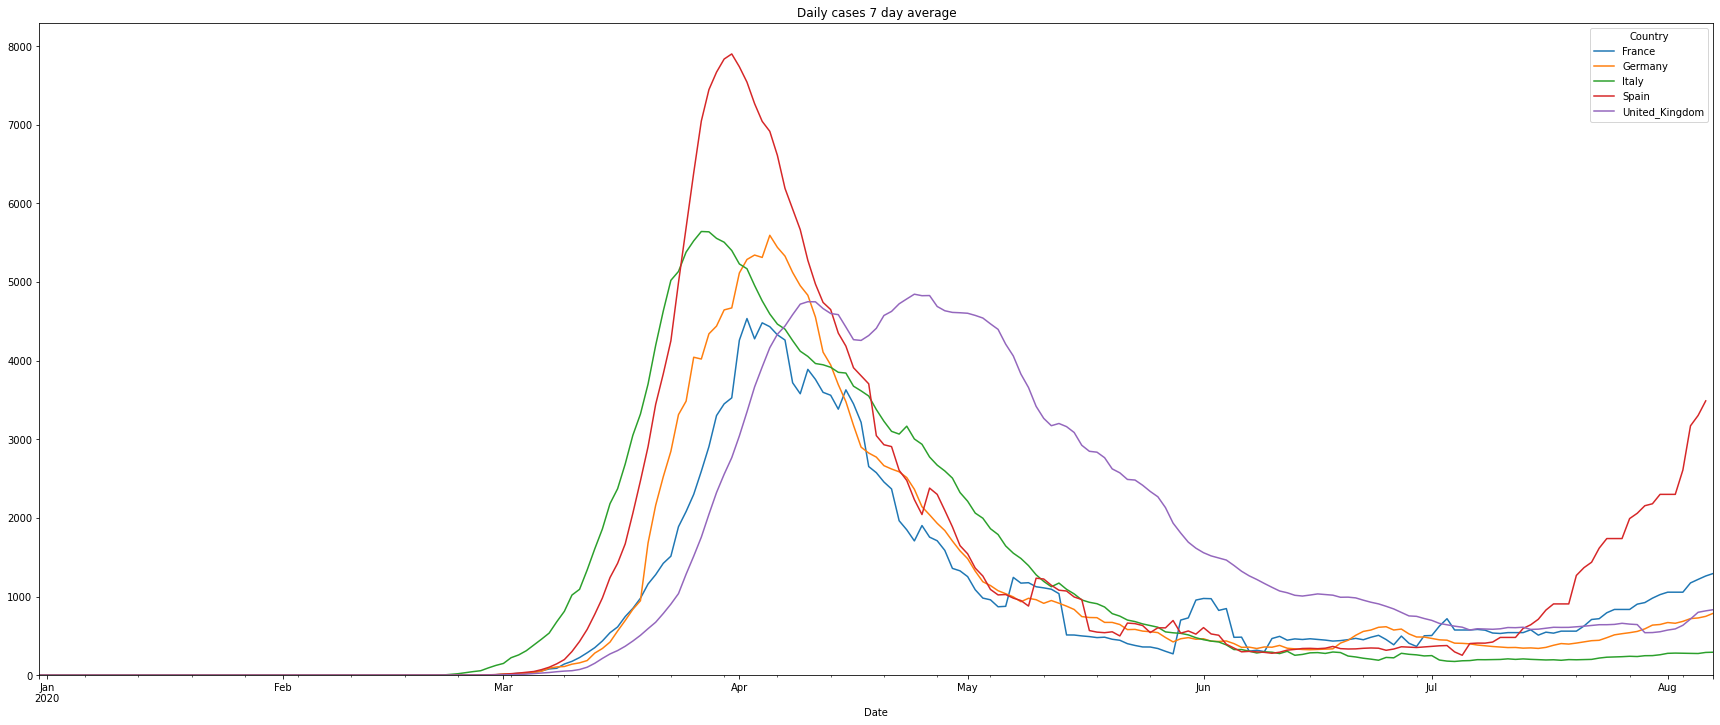

In [27]:

# filter the data of the number of daily cases
df = covidCases.add_lowpass_filter_for_attribute(df, 'Cases', 7)

# plot the filtered daily cases
(PlotterBuilder('Cases7')
     .set_figsize((30, 12))
     .set_title('Daily cases 7 day average')
     .plot_dataFrame(df, ylim_min=0))



Now the graphs of the deaths. For the graph of the daily deaths we again use a 7 day average:


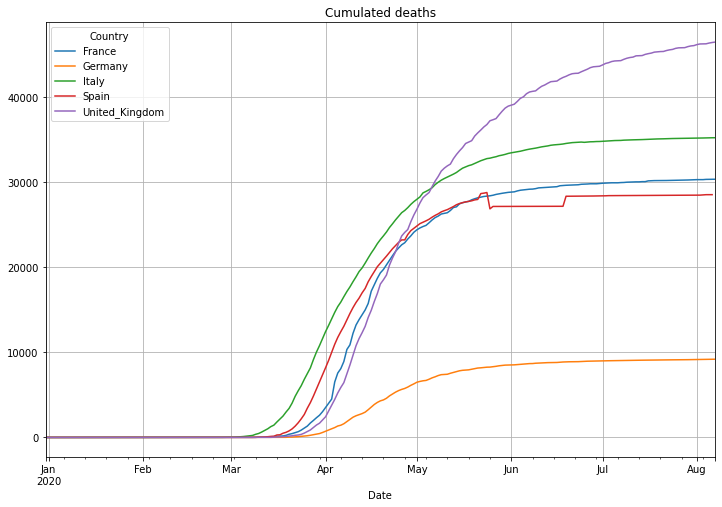

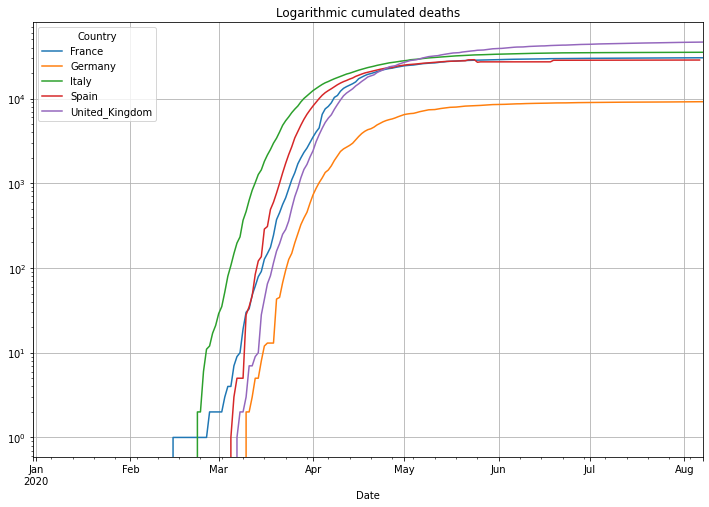

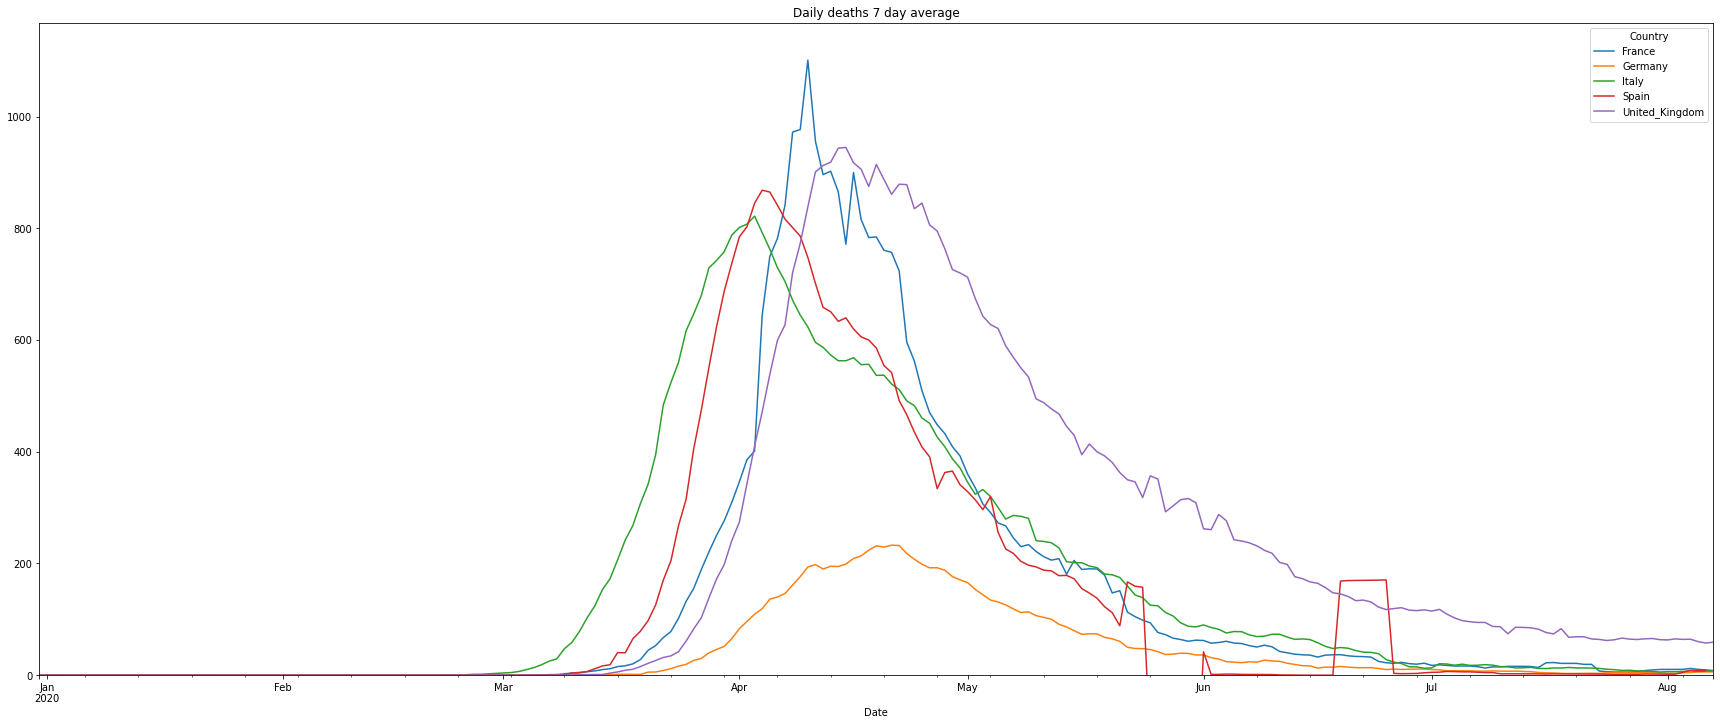

In [28]:

# plot cumulated deaths
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     .set_grid()
     .plot_dataFrame(df))

# plot cumulated deaths in logarithmic y-axis scale
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     .set_grid()
     .set_log()
     .plot_dataFrame(df))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'Deaths', 7)

# plot the filtered daily cases
(PlotterBuilder('Deaths7')
     .set_figsize((30, 12))
     .set_title('Daily deaths 7 day average')
     .plot_dataFrame(df, ylim_min=0))



Next is the number of deaths in percent of the cases. There is an interesting, not finished (17.04.2020), study in the village of Gangelt, Heinsberg county Germany, with 12000 citizen. A couple from the town was spending vacation in the Italian Lombardian area, the first hotspot in Italy. When they came back from vacation they attended 3 carnival parties in the village. Beside that the woman was working in a kinder garden. Both have been infected and the village became the first hotspot in Germany after a smaller outbreak at a Webasto fab in Bavaria. A team of the virology institute at the university of Bonn headed by professor Hendrik Streeck tested 509 persons of 240 households on antibodies of Sars-CoV-2. As a result they found out that statistically 15% of the citizen had already antibodies, meaning an infection with Covid-19. Taking the amount of infected people and the number of deaths in the village into account it turns out, that the death rate was only 0,37%, a pretty low number. This leads to a simple problem: if the reported number of cases is low, then the death rate will be significantly higher. Interestingly Germany is doing Covid-19 tests massively and the death rate is significantly lower than in other countries with a higher death rate. This might be an indicator of less tests and therefore a high number of 'dark cases', cases that are not confirmed due to not enough tests.


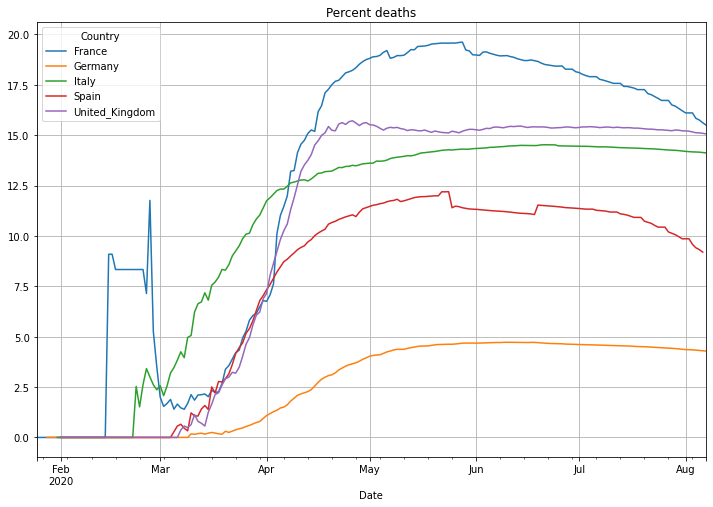

In [29]:

# plot the percent deaths with linear scale
(PlotterBuilder('PercentDeaths')
    .set_title('Percent deaths')
    .set_grid()
    .plot_dataFrame(df))



Now the number of cases per million population:
    

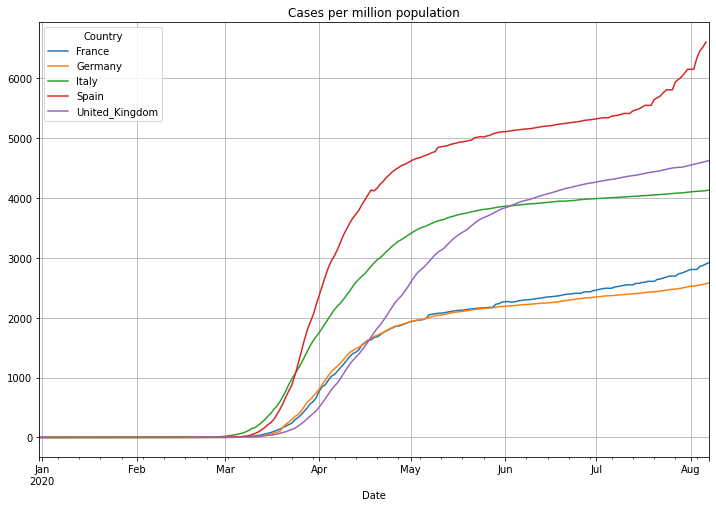

In [30]:

# plot the daily doubling time with linear scale
(PlotterBuilder('CasesPerMillionPopulation')
    .set_title('Cases per million population')
    .set_grid()
    .plot_dataFrame(df))



Now the number of deaths per million population. Be aware: some countries report not all deaths. The United Kingdom for instance reported in the beginning of the pandamic only people that died in NHS facilities:
    

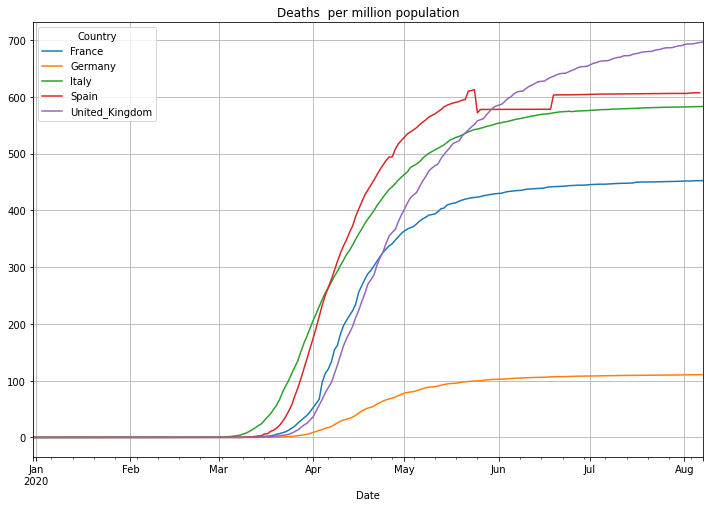

In [31]:

# plot the daily doubling time with linear scale
(PlotterBuilder('DeathsPerMillionPopulation')
    .set_title('Deaths  per million population')
    .set_grid()
    .plot_dataFrame(df))



Finally the doubling time which stands for the number of days it needs to double the number of cases. The number is useful during an exponential growth (roughly up to a number of 20 days). The higher this number, the less exponential and the better the situation is. After a pandemic becomes more linear it becomes more important to look to the reproduction rate, refer to the end of this document to view it. We also show a 7 day average of this number using a maximum value of 20 for the y-axis. By doing this we can see the start of the pandamic much esier.
    

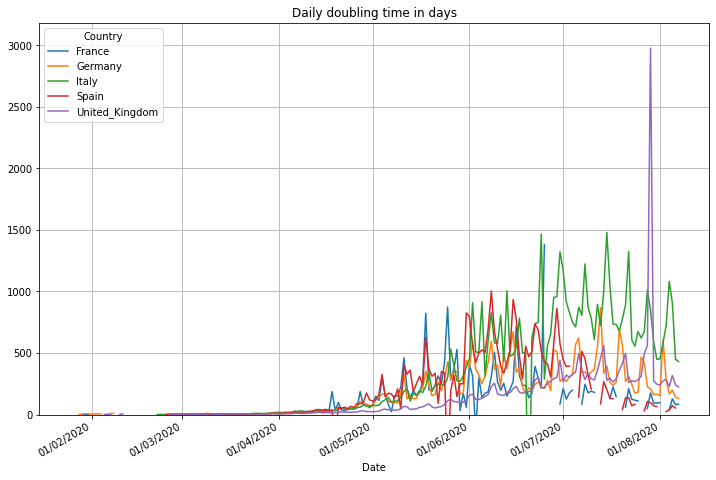

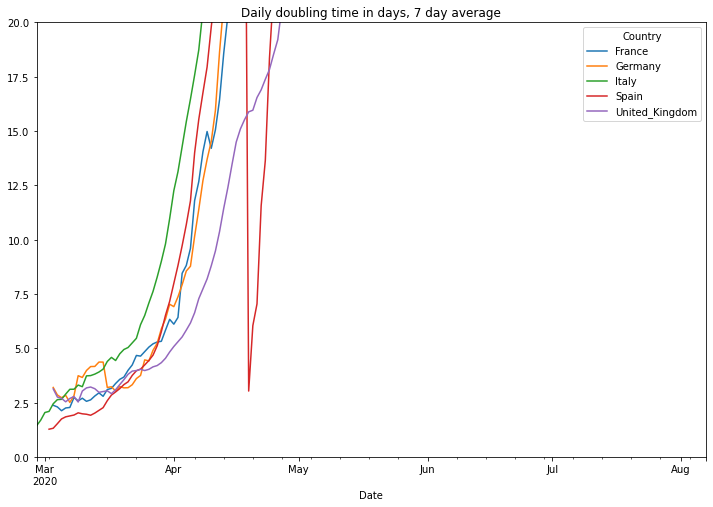

In [32]:

# plot the daily doubling time with linear scale
(PlotterBuilder('DoublingTime')
    .set_title('Daily doubling time in days')
    .set_grid()
    .plot_dataFrame(df, ylim_min=0))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'DoublingTime', 7)

# plot the filtered daily cases
(PlotterBuilder('DoublingTime7')
     .set_title('Daily doubling time in days, 7 day average')
     .plot_dataFrame(df, ylim_min=0, ylim_max=20))




Now we will align the data to the day when the cumulative cases first execeeded the number of 100 cases. This will help us understanding the different speed of the outbreak in different countries. Graphs which started delayed, or better, started horizontally shifted in the plots above will now be aligned on the left. The units on the horizontal axis is now <i>Number of Days</i>. Because of the alignment the graphs will be longer or shorter depending on the number of days since the country exceeded 100 cases.


/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in long_scalars
/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in long_scalars


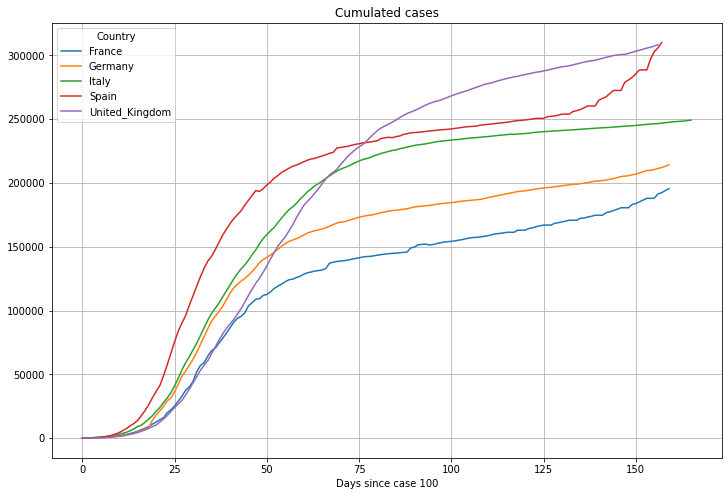

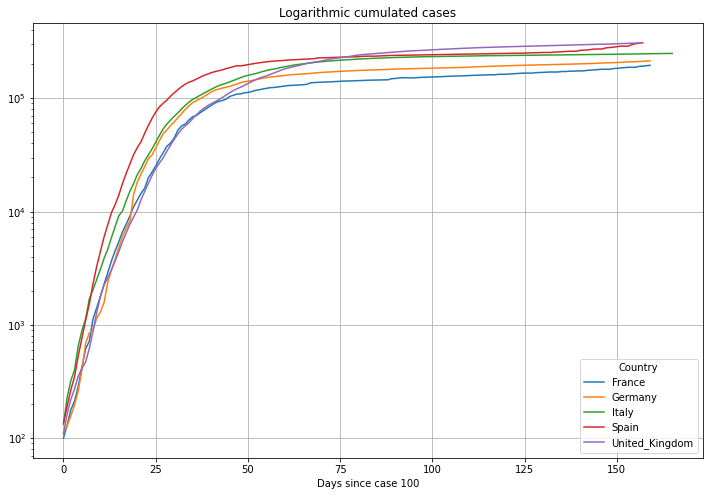

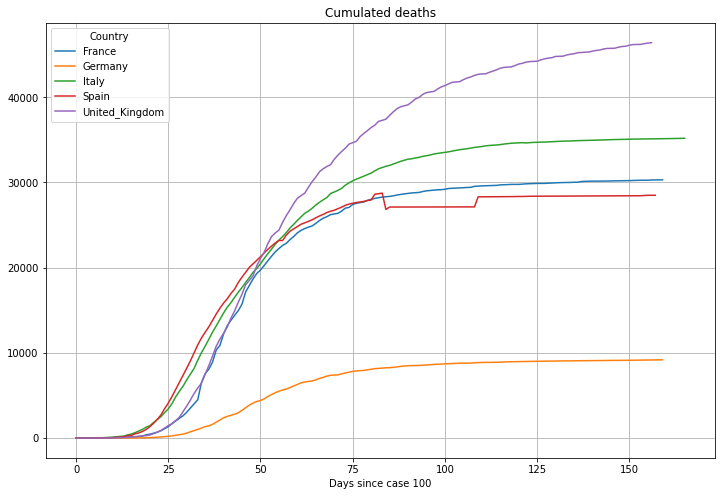

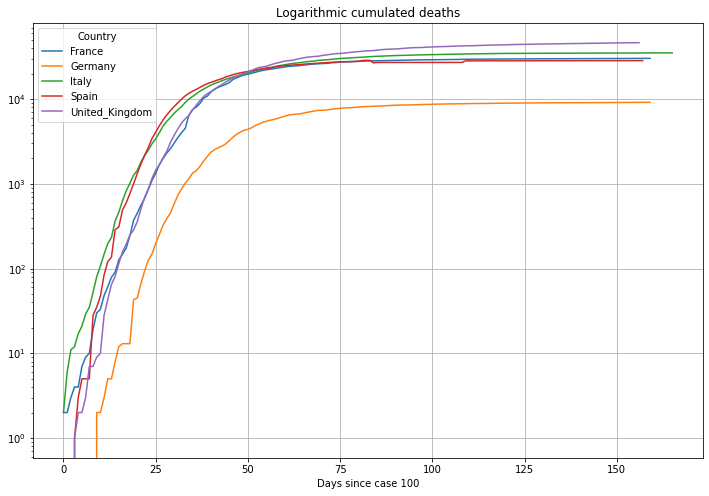

In [33]:

# the data starting at the first day after the cumalative cases have exceed 100 cases
numCasesStart = 100
# differntiate between a normal run and a github actions injected run path
if not githubAction:
    # get the data
    df = covidCases.get_country_data_by_geoid_string_list(countryList, sinceNcases=numCasesStart)
  
# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Logarithmic cumulated cases')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     .set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))


Lets take a closer look to the last 30 days.

/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in long_scalars
/Users/martinkersting/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in long_scalars


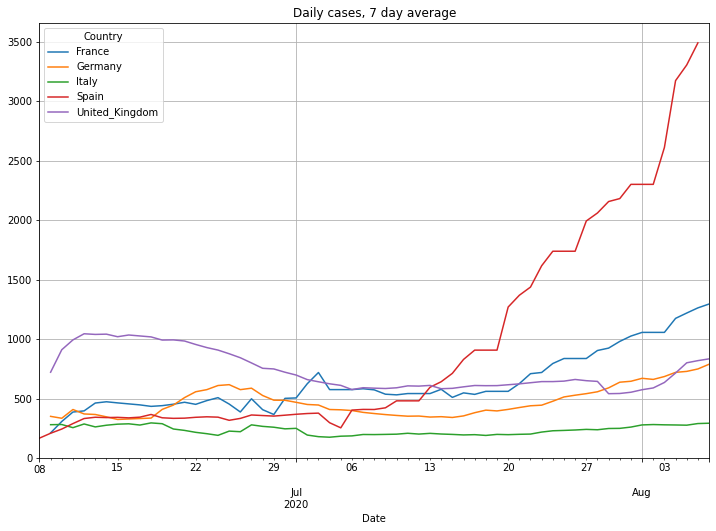

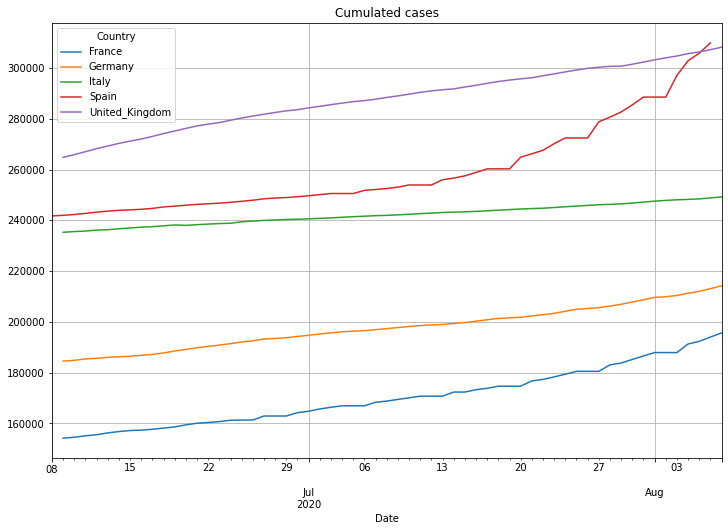

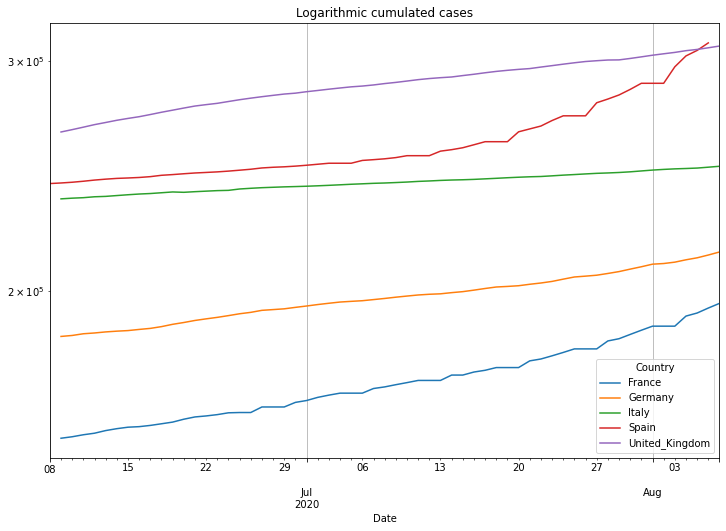

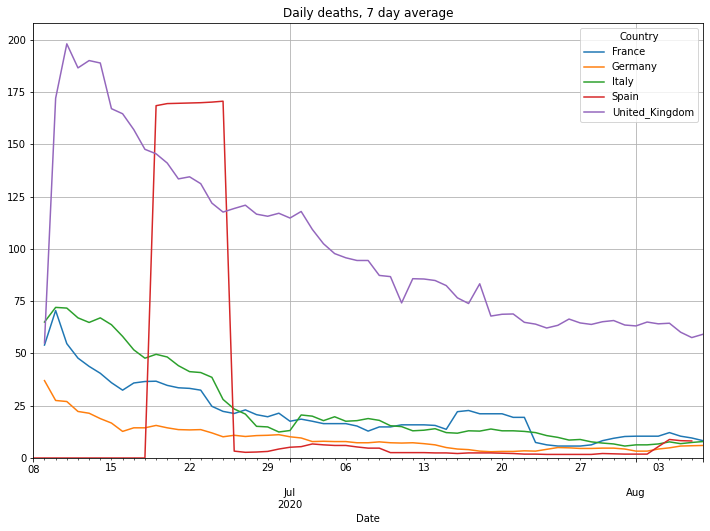

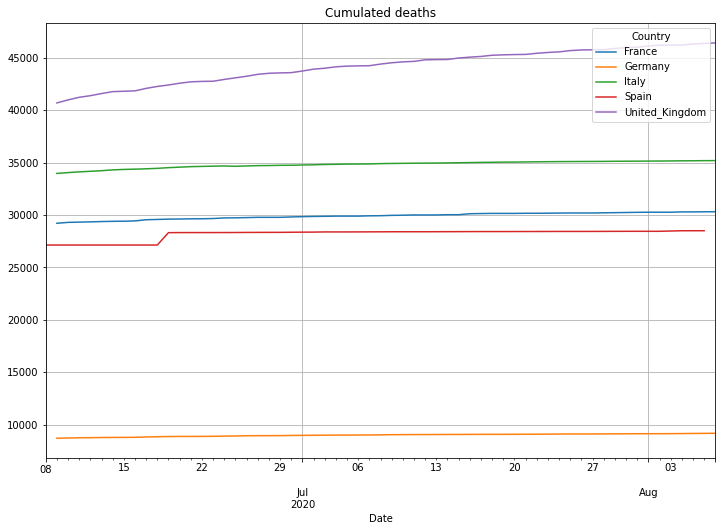

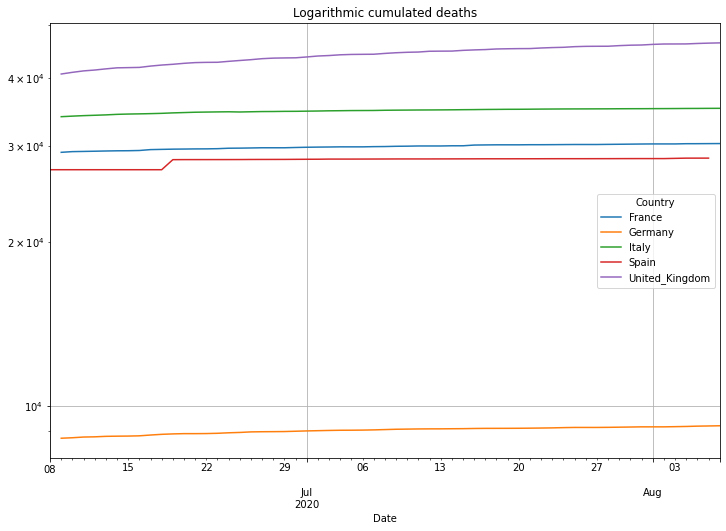

In [34]:

# the number of last days tolook at
numLastDays = 60
# differntiate between a normal run and a github actions injected run path
if not githubAction:
    # get the data
    df = covidCases.get_country_data_by_geoid_string_list(countryList, lastNdays=numLastDays)
    
# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'Cases', 7)

# plot daily cases
(PlotterBuilder('Cases7')
     .set_title('Daily cases, 7 day average')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df, ylim_min=0))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Cumulated cases')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeCases')
     .set_title('Logarithmic cumulated cases')
     #.set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# filter the data of the number of daily deaths
df = covidCases.add_lowpass_filter_for_attribute(df, 'Deaths', 7)

# plot daily cases
(PlotterBuilder('Deaths7')
     .set_title('Daily deaths, 7 day average')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df, ylim_min=0))

# plot cumulated deaths
(PlotterBuilder('CumulativeDeaths')
     .set_title('Cumulated deaths')
     #.set_xaxis_index()
     .set_grid()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))

# plot cumulated cases
(PlotterBuilder('CumulativeDeaths')
     .set_title('Logarithmic cumulated deaths')
     #.set_xaxis_index()
     .set_grid()
     .set_log()
     .set_axis_labels(xlabel='Last ' + str(numLastDays) + ' days')
     .plot_dataFrame(df))


An important but diffcult to calculate number is the basic reproduction number R0. The number defines how many people will be infected by one individual that is already infected. A number of 1.0 means that one infected person will infect one other person. As the original person will recover (or die) after some time, the number of infected people is constant. A number <1.0 means that the overall number of infected people will shrink, while a number >1.0 means that the overall number of infected people is increasing. This of course helps to predict the number of cases over time.   
The diffculty in calculating R0 is related to the at least 3 stages of an infection. In a first stage people are **S**usceptible for an infection, during the second stage people are **I**nfected and in the last stage they are **R**ecovered. The three characters S-I-R are giving the name for this model. The transition from stage to stage over time is what makes it diffcult to calculate the reproduction number R0. Refer to the SIR model and a online calculator:  
[https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)  
[http://covidsim.eu](http://covidsim.eu)  
  
The RKI published a method to calculate R0 here (German language):  
[https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/R-Wert-Erlaeuterung.pdf?__blob=publicationFile).    
  
The method is based on a so called *NowCasting*. Information about this can be found (German language) here:  
[https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y](https://edoc.rki.de/bitstream/handle/176904/6650.2/17_2020_2.Artikel.pdf?sequence=3&isAllowed=y). 
  
Unfortunately the data provided by the WHO is not enough and we haven't implemented nowcasting so that we use a different method here. This method produces slightly different values but it produces the similar trend information. Compared to the data of the RKI this calculation shows an average difference to the RKI values of 6% with a maximum difference of 13% for the data in May.  
**Be aware!** The doubling number produces a good estimation during the exponential phase of a pandamic, while R0 can be used as an indicator of the progress of a pandamic during a more or less linear groth rate. So only look to R0 values between 0.0 and 2.5, maybe even 1.0 to 3.0. (**Notice**: UK did something very strange: early July they reported -30000 new cases. The fact that a country corrects previous numbers is somehow normal. But correcting 30000 cases at one day makes it very difficult to analyse the data. Because of that the UK numbers for R0 around the beginning of July are incorrect. 
  

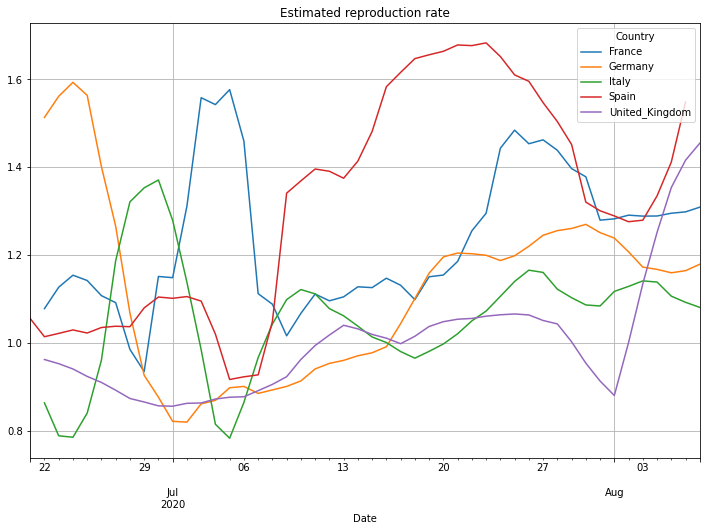

In [35]:

# get the unfiltered R number
df = covidCases.add_r0(df)
# apply a 7 day average
df = covidCases.add_lowpass_filter_for_attribute(df, 'R', 7)
# plot it
(PlotterBuilder('R7')
     .set_title('Estimated reproduction rate')
     #.set_xaxis_index()
     #.set_log()
     .set_grid()
     .set_axis_labels(xlabel='Days since case ' + str(numCasesStart))
     .plot_dataFrame(df))
